In [36]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%load_ext jupyternotify
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
from __future__ import division
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.calibration import calibration_curve
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
import pickle
from xauc import * 

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## load datasets

In [26]:
dataset_stumps = ['compas', 'frm', 'german', 'adult']
for ds in dataset_stumps: 
    data = pickle.load(open(ds+'_processed.p','rb'))
    globals().update(**data)


('dataset: ', 'COMPAS')
('test accuracy lr', 0.6596434359805511)
AUCs [(0.718973225354355, array([0.69081492, 0.74713153]), 'black'), (0.6817047471162377, array([0.63850981, 0.72489969]), 'white')]
XAUCs [0.41586495664501666, 0.20156546322961297]
('xauc fwds from delong', 0.41586495664501655, array([0.37252625, 0.45920366]))
('xauc bwds from delong', 0.201565463229613, array([0.17378578, 0.22934514]))
('test accuracy lr', 0.6742301458670988)
AUCs [(0.7376324834730048, array([0.71010505, 0.76515991]), 'black'), (0.7015860692102928, array([0.65957279, 0.74359935]), 'white')]
XAUCs [0.39513369160265077, 0.19029641076069398]
('xauc fwds from delong', 0.39513369160265066, array([0.3532833 , 0.43698408]))
('xauc bwds from delong', 0.19029641076069392, array([0.16287428, 0.21771854]))
('test accuracy lr calibrated', 0.6645056726094003)
AUCs [(0.7217357716469057, array([0.69367625, 0.74979529]), 'black'), (0.6876497338065662, array([0.64493008, 0.73036939]), 'white')]
XAUCs [0.4174540898750453

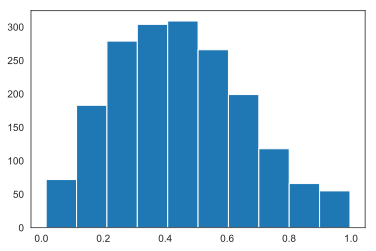

<Figure size 432x288 with 0 Axes>

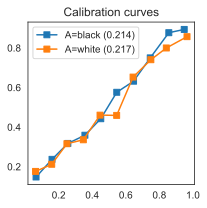

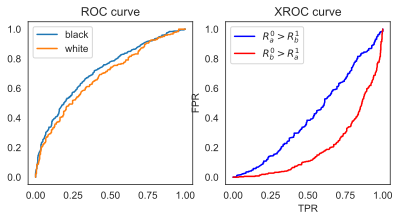

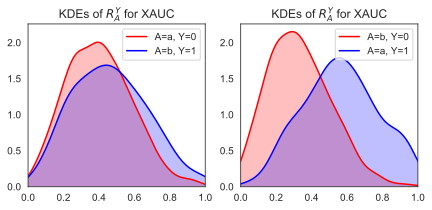

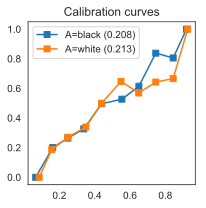

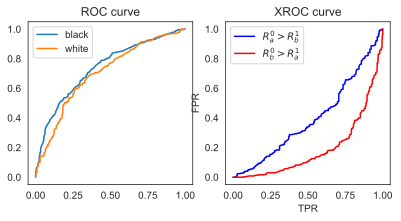

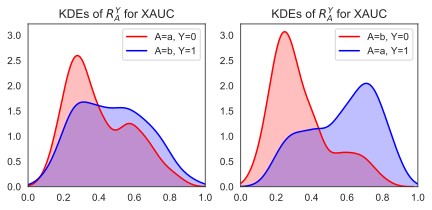

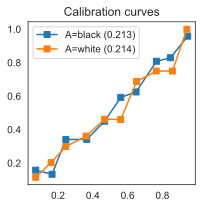

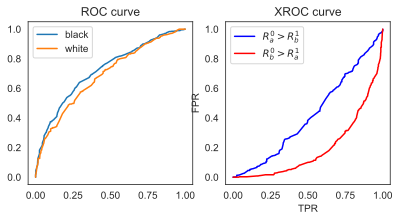

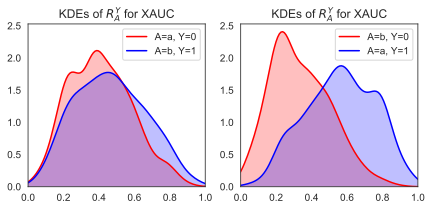

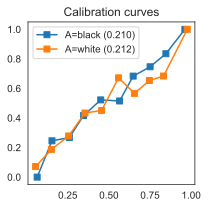

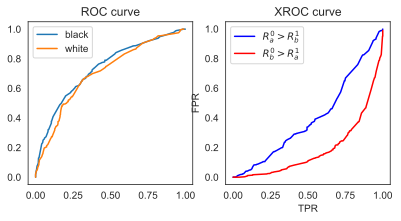

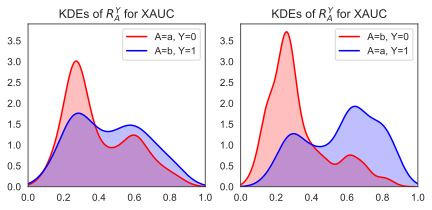

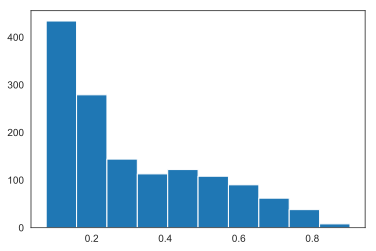

<Figure size 432x288 with 0 Axes>

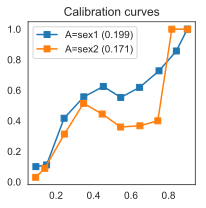

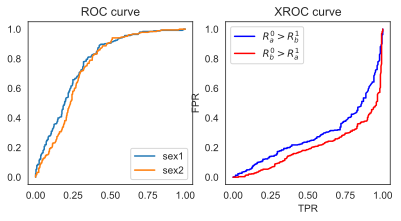

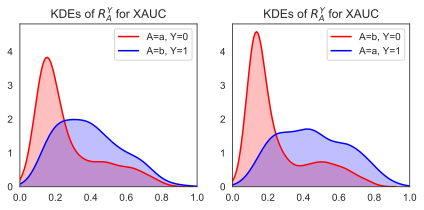

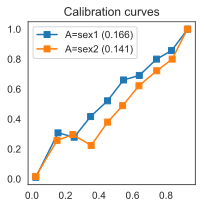

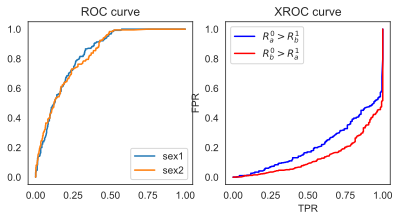

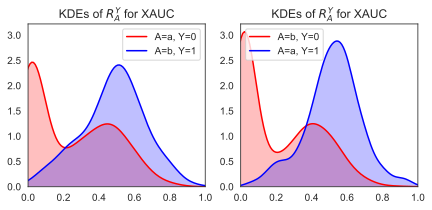

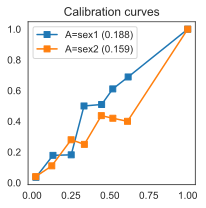

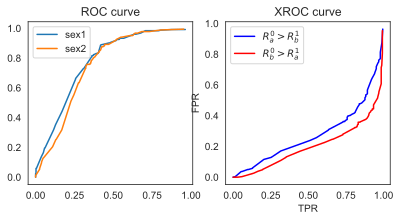

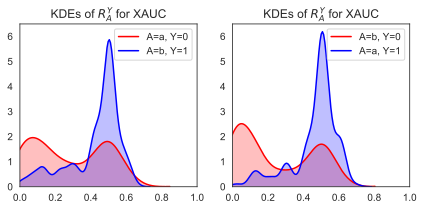

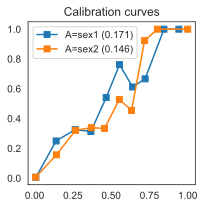

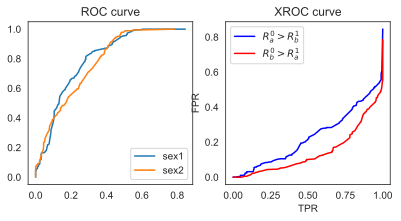

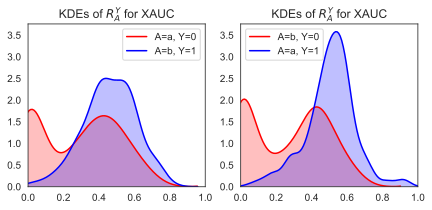

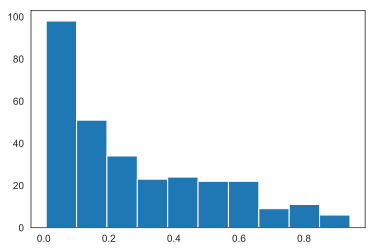

<Figure size 432x288 with 0 Axes>

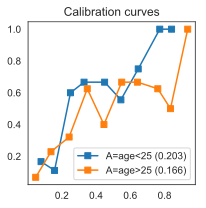

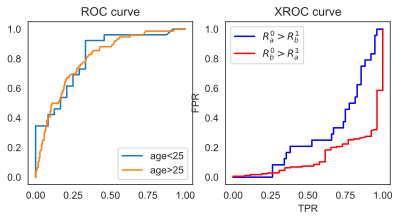

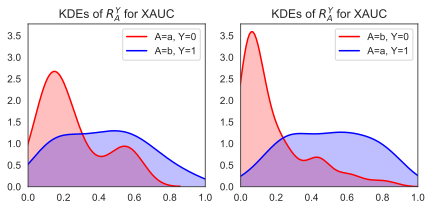

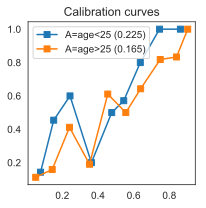

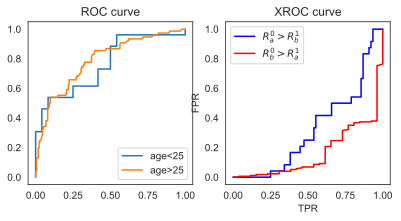

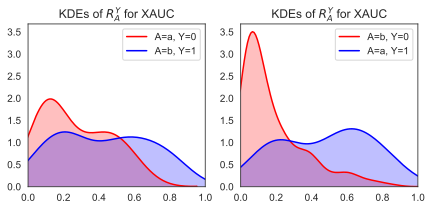

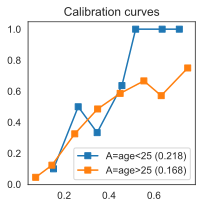

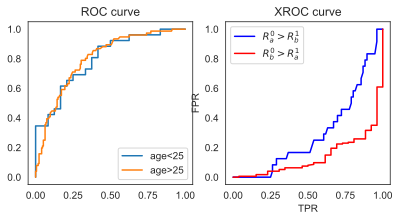

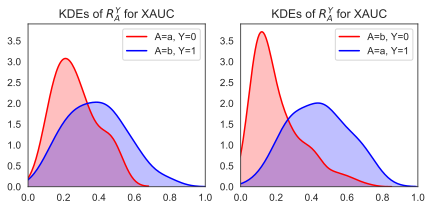

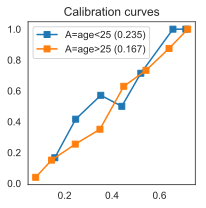

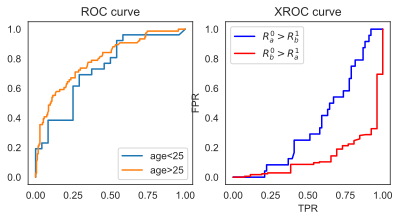

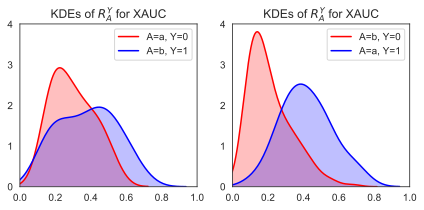

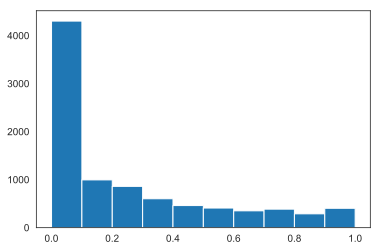

<Figure size 432x288 with 0 Axes>

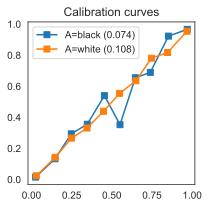

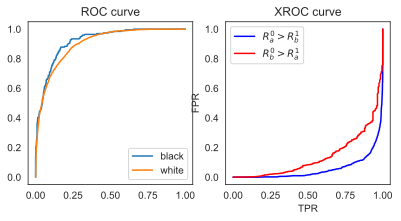

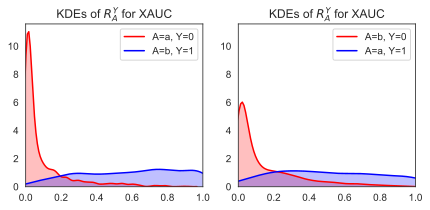

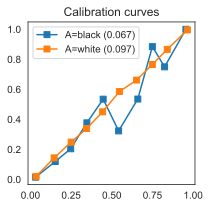

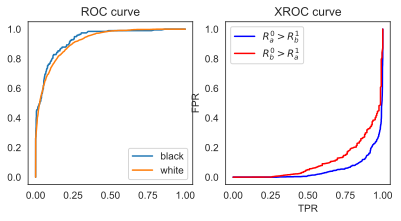

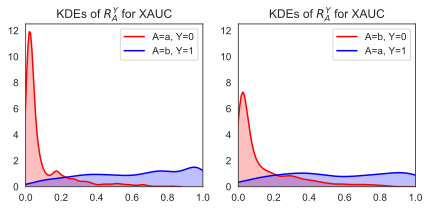

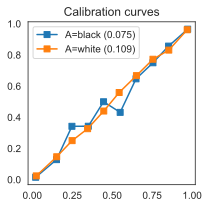

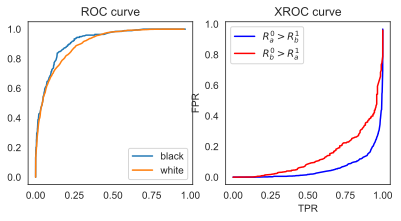

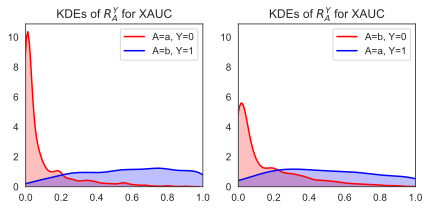

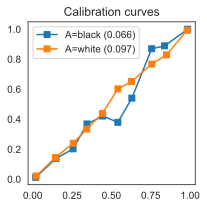

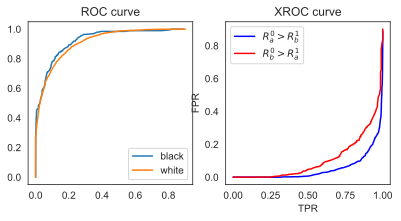

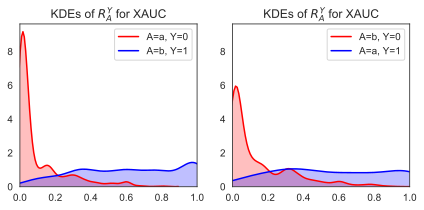

In [75]:
# We can also fix to load dataset within the loop 
import random
from sklearn.ensemble import GradientBoostingClassifier
random.seed(1)

cmps = [X_compas, A_compas, Y_compas, classes_compas, 'COMPAS']
frm = [X_frm, A_frm, Y_frm, classes_frm, 'framingham']
gmn = [X_german, A_german, Y_german, classes_german, 'german']
adt = [X_adult, A_adult, Y_adult, classes_adult, 'adult']

calibrators = [ get_calibrated_isotonic, get_calibrated_isotonic, get_calibrated_sigmoid, get_calibrated_isotonic]
datasets = [cmps, frm, gmn, adt]

TEST_SIZE = 0.3
N_THRESH = 1000
RES_lr = [None] * len(datasets); RES_lr_calib = [None] * len(datasets)
RES_xgb = [None] * len(datasets); RES_xgb_calib = [None] * len(datasets)


for ind,dataset in enumerate(datasets): 
    [X,A,Y, labels, name] = dataset
    print('dataset: ',name)
    ### Diagnostics for logistic regresison
    x_train, x_test, y_train, y_test, A_train, A_test, train_ind, test_ind = train_test_split(X, Y, A, range(len(A)), test_size = TEST_SIZE)
    [clf_lr, Rhat_train] = get_lr(x_train, y_train)
    Rhat_test = clf_lr.predict_proba(x_test)[:,1]
    print('test accuracy lr', clf_lr.score(x_test, y_test) ) # test accuracy
    plt.figure()
    plt.hist(Rhat_test)
    plt.figure()
#     [xauc_a0_b1, ci_a0_b1, xauc_b0_a1, ci_b0_a1] = get_cross_auc_delong(Rhat_test, y_test, A_test)
#     print('xauc fwds from delong', xauc_a0_b1, ci_a0_b1)
#     print('xauc bwds from delong', xauc_b0_a1, ci_b0_a1)
#     res = get_diagnostics(Rhat_test, x_test, A_test, y_test,labels, N_THRESH, stump=name, save = True)
#     [AUCs, briers, ROCs, XROC, XROC_backwards, Rhata0_cross_Rhatb1,Rhatb0_cross_Rhata1] = res
#     RES_lr[ind] = res
    res = get_diagnostics(Rhat_test, x_test, A_test, y_test,labels, N_THRESH, stump=name, save = True)
    RES_lr[ind] = res
    
    ### Diagnostics for XGBoost
    clf_gb = GradientBoostingClassifier()
    clf_gb = clf_gb.fit(x_train, y_train)
    print('test accuracy lr', clf_gb.score(x_test, y_test) ) # test accuracy
    Rhat_test = clf_gb.predict_proba(x_test)[:,1]; Rhat_all = clf_gb.predict_proba(X)[:,1]
    res_xgb = get_diagnostics(Rhat_test, x_test, A_test, y_test, labels, N_THRESH, stump=name+str("-xgb"), save = True)
    RES_xgb[ind] = res_xgb
    
    ### Calibrate the Logistic Regression (just in case not well-calibrated previously)
    CALIBRATOR = calibrators[ind]
    [clf_lr_calib, prob_lr_calib] = CALIBRATOR(clf_lr, x_train, x_test, y_train)
    print('test accuracy lr calibrated', clf_lr_calib.score(x_test, y_test) ) # test accuracy
    res_lr_calib = get_diagnostics(prob_lr_calib, x_test, A_test, y_test, labels, N_THRESH, stump=name+str("-calib-lr"), save = True)
    RES_lr_calib[ind] = res_lr_calib
    
    ### XGB calibrated 
    [clf_xgb_calib, prob_xgb_calib] = CALIBRATOR(clf_gb, x_train, x_test, y_train)
    print('test accuracy xgb calibrated', clf_xgb_calib.score(x_test, y_test) ) # test accuracy
    res_xgb_calib = get_diagnostics(prob_xgb_calib, x_test, A_test, y_test, labels, N_THRESH, stump=name+str("-calib-xgb"), save = True)
    RES_xgb_calib[ind] = res_xgb_calib

    

In [116]:
for ind,dataset in enumerate(datasets): 
    [X,A,Y, labels, name] = dataset
    print X.shape

(6167, 402)
(4658, 7)
(1000, 57)
(30162, 98)


In [79]:
# Build numpy array out of RESULTS objects with relevant metrics

def parse_results(RES_): 
    nrow = 3 # 4 summary statistics 
    ncol = len(RES_)*2 # for binary sens attribute
    TABLE = np.zeros([nrow,ncol])
    for j, res in enumerate(RES_):
        [AUCs, AUCs_CIs, briers, ROCs, XROC, XROC_backwards, XAUCs, XCIs] = res
        TABLE[0,2*j:2*j+2] = np.round(AUCs,3) 
        TABLE[1,2*j:2*j+2] = np.round(briers,3)
        TABLE[2,2*j:2*j+2] = np.round(XAUCs,3)
    return TABLE

lr_table = parse_results( RES_lr )
xgb_table = parse_results( RES_xgb )
lr_calib_table = parse_results( RES_lr_calib )
xgb_calib_table = parse_results( RES_xgb_calib )

print lr_table
print lr_calib_table
print xgb_table
print xgb_calib_table

RES_table = np.vstack([lr_table, lr_calib_table, xgb_table, xgb_calib_table])

[[0.719 0.682 0.774 0.747 0.812 0.8   0.919 0.902]
 [0.214 0.217 0.199 0.171 0.203 0.166 0.074 0.108]
 [0.416 0.202 0.283 0.204 0.287 0.135 0.055 0.137]]
[[0.722 0.688 0.774 0.748 0.796 0.799 0.917 0.901]
 [0.213 0.214 0.188 0.159 0.218 0.168 0.075 0.109]
 [0.417 0.195 0.279 0.205 0.294 0.137 0.055 0.141]]
[[0.738 0.702 0.831 0.826 0.763 0.786 0.931 0.919]
 [0.208 0.213 0.166 0.141 0.225 0.165 0.067 0.097]
 [0.395 0.19  0.21  0.136 0.321 0.163 0.05  0.107]]
[[0.733 0.704 0.823 0.804 0.731 0.792 0.93  0.919]
 [0.21  0.212 0.171 0.146 0.235 0.167 0.066 0.097]
 [0.398 0.189 0.23  0.145 0.359 0.133 0.05  0.107]]


In [84]:
RES_table
nrows_total = RES_table.shape[0]
for i in range(nrows_total): #iterate over rows 
    print " & ".join([ '$'+ str(RES_table[i,j]) + '$' for j in range(RES_table.shape[1]) ])  + '\\\\'



$0.719$ & $0.682$ & $0.774$ & $0.747$ & $0.812$ & $0.8$ & $0.919$ & $0.902$\\
$0.214$ & $0.217$ & $0.199$ & $0.171$ & $0.203$ & $0.166$ & $0.074$ & $0.108$\\
$0.416$ & $0.202$ & $0.283$ & $0.204$ & $0.287$ & $0.135$ & $0.055$ & $0.137$\\
$0.722$ & $0.688$ & $0.774$ & $0.748$ & $0.796$ & $0.799$ & $0.917$ & $0.901$\\
$0.213$ & $0.214$ & $0.188$ & $0.159$ & $0.218$ & $0.168$ & $0.075$ & $0.109$\\
$0.417$ & $0.195$ & $0.279$ & $0.205$ & $0.294$ & $0.137$ & $0.055$ & $0.141$\\
$0.738$ & $0.702$ & $0.831$ & $0.826$ & $0.763$ & $0.786$ & $0.931$ & $0.919$\\
$0.208$ & $0.213$ & $0.166$ & $0.141$ & $0.225$ & $0.165$ & $0.067$ & $0.097$\\
$0.395$ & $0.19$ & $0.21$ & $0.136$ & $0.321$ & $0.163$ & $0.05$ & $0.107$\\
$0.733$ & $0.704$ & $0.823$ & $0.804$ & $0.731$ & $0.792$ & $0.93$ & $0.919$\\
$0.21$ & $0.212$ & $0.171$ & $0.146$ & $0.235$ & $0.167$ & $0.066$ & $0.097$\\
$0.398$ & $0.189$ & $0.23$ & $0.145$ & $0.359$ & $0.133$ & $0.05$ & $0.107$\\


In [115]:
def parse_cis(RES_): 
    nrow = 2 # 4 summary statistics 
    ncol = len(RES_)*2 # for binary sens attribute
    auc_row = [None]*ncol; xauc_row = [None]*ncol; 
    for j, res in enumerate(RES_):
        [AUCs, AUCs_CIs, briers, ROCs, XROC, XROC_backwards, XAUCs, XCIs] = res
        AUCs_CIs = [ tuple(ci) for ci in AUCs_CIs ]
        XCIs = [ tuple(ci) for ci in XCIs ]
        for a in (np.unique(A)): 
            auc_row[2*j+a] = np.round(AUCs_CIs[a],3) 
            xauc_row[2*j+a] = np.round(XCIs[a],3)
    print '$\op{AUC}$ & ' + " & ".join([ '$['+ ",".join([str(x) for x in auc_row[2*j]]) + "]$ & $[" + ",".join([str(x) for x in auc_row[2*j+1] ]) + ']$' for j in range(len(RES_)) ])  + '\\\\'
    print '$\op{XAUC}$ & ' +" & ".join([ '$['+ ",".join([str(x) for x in xauc_row[2*j]]) + "]$ & $[" + ",".join([str(x) for x in xauc_row[2*j+1] ]) + ']$' for j in range(len(RES_)) ])  + '\\\\'

res_models = [RES_lr, RES_xgb, RES_lr_calib, RES_xgb_calib]
[ parse_cis(res) for res in res_models ]

$\op{AUC}$ & $[0.691,0.747]$ & $[0.639,0.725]$ & $[0.738,0.81]$ & $[0.711,0.782]$ & $[0.691,0.934]$ & $[0.743,0.858]$ & $[0.901,0.938]$ & $[0.895,0.909]$\\
$\op{XAUC}$ & $[0.373,0.459]$ & $[0.174,0.229]$ & $[0.24,0.325]$ & $[0.174,0.234]$ & $[0.174,0.4]$ & $[0.073,0.196]$ & $[0.047,0.062]$ & $[0.114,0.16]$\\
$\op{AUC}$ & $[0.71,0.765]$ & $[0.66,0.744]$ & $[0.8,0.862]$ & $[0.796,0.855]$ & $[0.629,0.896]$ & $[0.724,0.849]$ & $[0.914,0.949]$ & $[0.913,0.926]$\\
$\op{XAUC}$ & $[0.353,0.437]$ & $[0.163,0.218]$ & $[0.174,0.246]$ & $[0.112,0.16]$ & $[0.207,0.434]$ & $[0.085,0.241]$ & $[0.042,0.057]$ & $[0.086,0.127]$\\
$\op{AUC}$ & $[0.694,0.75]$ & $[0.645,0.73]$ & $[0.738,0.81]$ & $[0.713,0.784]$ & $[0.674,0.919]$ & $[0.742,0.857]$ & $[0.899,0.936]$ & $[0.894,0.908]$\\
$\op{XAUC}$ & $[0.374,0.46]$ & $[0.167,0.222]$ & $[0.238,0.322]$ & $[0.175,0.235]$ & $[0.181,0.407]$ & $[0.073,0.2]$ & $[0.047,0.063]$ & $[0.118,0.164]$\\
$\op{AUC}$ & $[0.706,0.761]$ & $[0.662,0.746]$ & $[0.791,0.854]$ & $[0.

[None, None, None, None]

(8, 8, 2, 2)